# Generate Simple Rate-Based Mock Data

Generate a simple price series where:
- High message rate → Price increases
- Low message rate → Price decreases

This makes temporal learning essential as the only way to predict price is to understand message arrival patterns.

In [8]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

## Generate Timestamps with Varying Rates

In [9]:
# Simulation parameters
total_duration = 36000  # 10 hours in seconds
base_rate = 1.0         # Base message rate (messages per second)

# Create more frequent periods of different activity
# More dynamic pattern with 20 periods instead of 5
n_periods = 20
period_duration = total_duration / n_periods  # Each period is 30 minutes

# Create alternating pattern with varying intensities
np.random.seed(42)
rate_pattern = []
for i in range(n_periods):
    if i % 2 == 0:  # Even periods: low activity
        rate_pattern.append(0.2 + 0.3 * np.random.random())  # 0.2 to 0.5
    else:  # Odd periods: high activity  
        rate_pattern.append(1.5 + 1.5 * np.random.random())  # 1.5 to 3.0

print(f"Rate pattern (20 periods of {period_duration/60:.0f} minutes each):")
print(f"Low periods: {[f'{r:.2f}' for i, r in enumerate(rate_pattern) if i % 2 == 0]}")
print(f"High periods: {[f'{r:.2f}' for i, r in enumerate(rate_pattern) if i % 2 == 1]}")

# Generate timestamps
timestamps = []
current_time = 0.0

for period_idx, rate_mult in enumerate(rate_pattern):
    period_start = period_idx * period_duration
    period_end = (period_idx + 1) * period_duration
    current_rate = base_rate * rate_mult
    
    while current_time < period_end and current_time < total_duration:
        # Exponential distribution for realistic inter-arrival times
        interval = np.random.exponential(1.0 / current_rate)
        current_time += interval
        if current_time < period_end:
            timestamps.append(current_time)

timestamps = np.array(timestamps)
print(f"\nGenerated {len(timestamps)} messages over {total_duration/3600:.1f} hours")
print(f"Average rate: {len(timestamps)/total_duration:.2f} messages/second")

Rate pattern (20 periods of 30 minutes each):
Low periods: ['0.31', '0.42', '0.25', '0.22', '0.38', '0.21', '0.45', '0.25', '0.29', '0.33']
High periods: ['2.93', '2.40', '1.73', '2.80', '2.56', '2.95', '1.82', '1.78', '2.29', '1.94']

Generated 47383 messages over 10.0 hours
Average rate: 1.32 messages/second


## Calculate Local Message Rates

In [10]:
from numba import njit

# Calculate message rate using a sliding window
window_size = 60.0  # 60 second window for rate calculation

@njit
def calculate_local_rate(timestamps, window_size=60.0):
    """Calculate local message rate for each timestamp."""
    rates = np.zeros(len(timestamps))
    
    for i, t in enumerate(timestamps):
        # Count messages in window [t - window_size, t]
        window_start = t - window_size
        count = np.sum((timestamps >= window_start) & (timestamps <= t))
        rates[i] = count / window_size
    
    return rates

# Calculate rates (this might take a moment)
print("Calculating local message rates...")
local_rates = calculate_local_rate(timestamps, window_size)
print(f"Rate range: {local_rates.min():.2f} to {local_rates.max():.2f} messages/second")

Calculating local message rates...
Rate range: 0.02 to 3.78 messages/second


## Generate Rate-Based Prices

In [11]:
# Price directly influenced by message rate
base_price = 100.0
price_sensitivity = 10.0  # Price change per unit rate change

# Initialize prices
prices = np.zeros(len(timestamps))
prices[0] = base_price

# Price follows rate with some lag and smoothing
smoothing_factor = 0.98  # Momentum/smoothing
rate_impact = 0.02       # How much new rate affects price

for i in range(1, len(timestamps)):
    # Target price based on current rate
    rate_deviation = local_rates[i] - 1.0  # Deviation from base rate
    target_price = base_price + price_sensitivity * rate_deviation
    
    # Smooth price movement (momentum)
    prices[i] = smoothing_factor * prices[i-1] + rate_impact * target_price
    
    # Add small noise for realism
    prices[i] += np.random.normal(0, 0.01)

print(f"Price range: ${prices.min():.2f} to ${prices.max():.2f}")
print(f"Base price: ${base_price:.2f}")
print(f"Price correlation with rate: {np.corrcoef(local_rates, prices)[0,1]:.3f}")

Price range: $91.98 to $126.31
Base price: $100.00
Price correlation with rate: 0.972


## Visualize the Relationship

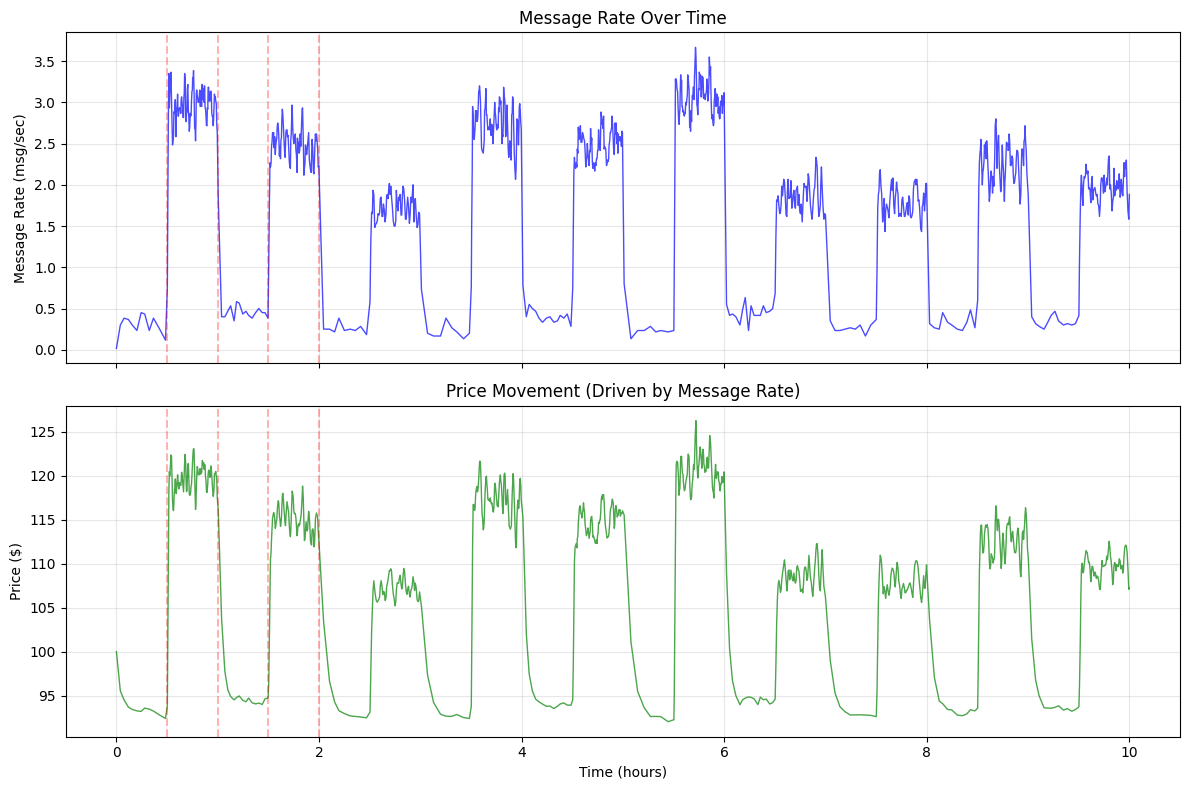


Period Statistics:
Period 1: Rate multiplier=0.3, Avg rate=0.31 msg/s, Avg price=$93.80
Period 2: Rate multiplier=2.9, Avg rate=2.93 msg/s, Avg price=$119.05
Period 3: Rate multiplier=0.4, Avg rate=0.48 msg/s, Avg price=$96.23
Period 4: Rate multiplier=2.4, Avg rate=2.47 msg/s, Avg price=$114.47
Period 5: Rate multiplier=0.2, Avg rate=0.28 msg/s, Avg price=$95.11
Period 6: Rate multiplier=1.7, Avg rate=1.70 msg/s, Avg price=$106.76
Period 7: Rate multiplier=0.2, Avg rate=0.26 msg/s, Avg price=$94.29
Period 8: Rate multiplier=2.8, Avg rate=2.70 msg/s, Avg price=$116.77
Period 9: Rate multiplier=0.4, Avg rate=0.43 msg/s, Avg price=$95.96
Period 10: Rate multiplier=2.6, Avg rate=2.46 msg/s, Avg price=$114.31
Period 11: Rate multiplier=0.2, Avg rate=0.25 msg/s, Avg price=$95.56
Period 12: Rate multiplier=3.0, Avg rate=3.02 msg/s, Avg price=$119.93
Period 13: Rate multiplier=0.4, Avg rate=0.47 msg/s, Avg price=$96.35
Period 14: Rate multiplier=1.8, Avg rate=1.84 msg/s, Avg price=$108.21
Pe

In [12]:
import matplotlib.pyplot as plt

# Sample for visualization (too many points otherwise)
sample_indices = np.arange(0, len(timestamps), max(1, len(timestamps)//1000))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot message rate
ax1.plot(timestamps[sample_indices] / 3600, local_rates[sample_indices], 
         'b-', linewidth=1, alpha=0.7)
ax1.set_ylabel('Message Rate (msg/sec)')
ax1.set_title('Message Rate Over Time')
ax1.grid(True, alpha=0.3)

# Plot price
ax2.plot(timestamps[sample_indices] / 3600, prices[sample_indices], 
         'g-', linewidth=1, alpha=0.7)
ax2.set_ylabel('Price ($)')
ax2.set_xlabel('Time (hours)')
ax2.set_title('Price Movement (Driven by Message Rate)')
ax2.grid(True, alpha=0.3)

# Add period boundaries
for i in range(1, 5):
    boundary = i * period_duration / 3600
    ax1.axvline(boundary, color='red', linestyle='--', alpha=0.3)
    ax2.axvline(boundary, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print period statistics
print("\nPeriod Statistics:")
for i, rate_mult in enumerate(rate_pattern):
    period_mask = (timestamps >= i * period_duration) & (timestamps < (i+1) * period_duration)
    if np.any(period_mask):
        avg_rate = local_rates[period_mask].mean()
        avg_price = prices[period_mask].mean()
        print(f"Period {i+1}: Rate multiplier={rate_mult:.1f}, "
              f"Avg rate={avg_rate:.2f} msg/s, Avg price=${avg_price:.2f}")

## Save to Parquet

In [13]:
# Create DataFrame
df = pd.DataFrame({
    'timestamp': np.array(timestamps * 1000, dtype=np.int64),  # Convert to milliseconds
    'price': prices,
    'message_rate': local_rates  # Include rate for analysis
})

# Remove any duplicates (shouldn't be any, but just in case)
df = df.drop_duplicates(subset='timestamp').reset_index(drop=True)

# Save to data directory
output_file = '../../data/mock.parquet'
os.makedirs('../../data', exist_ok=True)
df.to_parquet(output_file, index=False)

print(f"Saved {len(df)} records to {output_file}")
print(f"File size: {os.path.getsize(output_file) / 1024:.1f} KB")
print(f"\nDataFrame info:")
print(df.info())
print(f"\nFirst 10 rows:")
print(df.head(10))
print(f"\nLast 10 rows:")
print(df.tail(10))

Saved 47333 records to ../../data/mock.parquet
File size: 811.7 KB

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47333 entries, 0 to 47332
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     47333 non-null  int64  
 1   price         47333 non-null  float64
 2   message_rate  47333 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.1 MB
None

First 10 rows:
   timestamp       price  message_rate
0       3029  100.000000      0.016667
1       3510   99.809521      0.033333
2       4616   99.623538      0.050000
3       6077   99.439120      0.066667
4       8027   99.270446      0.083333
5      12950   99.100138      0.100000
6      13663   98.945749      0.116667
7      15975   98.816626      0.133333
8      18848   98.676895      0.150000
9      19000   98.534804      0.166667

Last 10 rows:
       timestamp       price  message_rate
47323   35995869  107.184816      1

## Verify Rate-Price Relationship

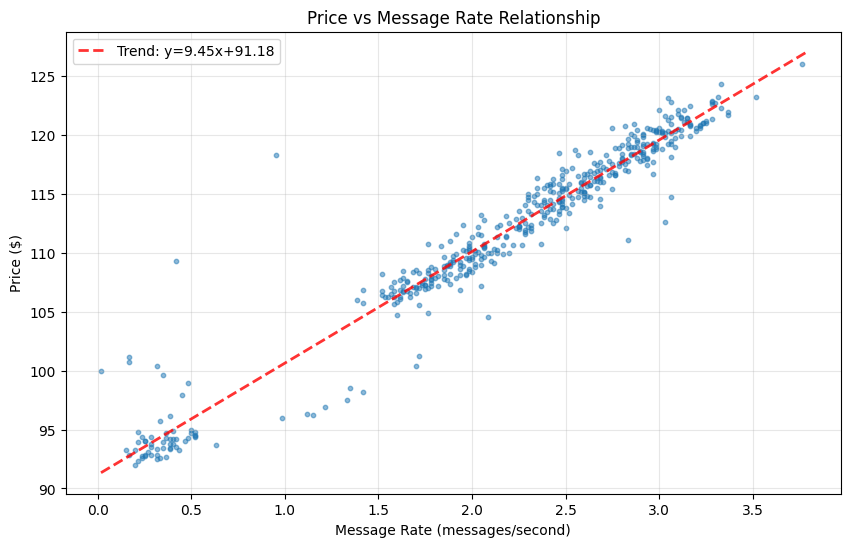


Key insight: To predict price movements, the model must learn to:
1. Track message arrival times
2. Estimate local message rates from temporal patterns
3. Predict future prices based on rate changes

This requires temporal memory and understanding of time intervals!


In [14]:
# Create scatter plot to show relationship
plt.figure(figsize=(10, 6))
plt.scatter(local_rates[::100], prices[::100], alpha=0.5, s=10)
plt.xlabel('Message Rate (messages/second)')
plt.ylabel('Price ($)')
plt.title('Price vs Message Rate Relationship')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(local_rates, prices, 1)
p = np.poly1d(z)
rate_range = np.linspace(local_rates.min(), local_rates.max(), 100)
plt.plot(rate_range, p(rate_range), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
plt.legend()
plt.show()

print(f"\nKey insight: To predict price movements, the model must learn to:")
print(f"1. Track message arrival times")
print(f"2. Estimate local message rates from temporal patterns")
print(f"3. Predict future prices based on rate changes")
print(f"\nThis requires temporal memory and understanding of time intervals!")